# Precipitation Frequency Table

__Description__: Auto-retrieve [NOAA Atlas 14](https://hdsc.nws.noaa.gov/hdsc/pfds/pfds_gis.html) precipitation statistics from [FTP](ftp://hdsc.nws.noaa.gov/pub/hdsc/data/) and calcualte the area-averaged precipitaiton frequency table for the area of interest (AOI).

__Input__: A vector polygon of the AOI, the NOAA Atlas 14 [volume](https://hdsc.nws.noaa.gov/hdsc/pfds/pfds_temporal.html) number, and durations of interest.

__Output__: A spreadsheet with tabs for each duration. Each tab contains a table for the given duration with area-averaged precipitation and confidence limits.

---

## Load Libraries, Parameters, and Data:

### Libraries:

In [1]:
import sys
sys.path.append('core')
from hydromet import*

### Parameters: 

#### Papermill (site specific):

In [2]:
## Atlas 14 volume number:
volume = 2


## Vector polygon information (.geojson, .shp, or .gdb):
polygon = 'AnacostiaR_HUC12.shp'


## Paths:
root_dir = pl.Path(os.getcwd())
inputs_dir = root_dir/'Inputs'
datarepository_dir = root_dir/'DataRepository'
polygon_dir = inputs_dir/polygon
outputs_dir = root_dir/'Outputs'

#### Global (project specific):

In [3]:
noaa_data_crs = {'init':'epsg:4326'} 

# If geopandas cannot read the projection info, add proj4 string here
brute_force_projection = "+proj=lcc +lat_1=39.45 +lat_2=38.3 +lat_0=37.66666666666666 +lon_0=-77 +x_0=399999.9998983998 +y_0=0 +ellps=GRS80 +datum=NAD83 +to_meter=0.3048006096012192 +no_defs"

durations = ['06h', '12h', '24h', '04d'] 
dur_names = ['6hr', '12hr', '24hr', '96hr']

vol_code_filename = 'NOAA_Atlas_Volume_Codes.json'

### Load Atlas 14 volume code from json:

In [4]:
vol_code = get_volume_code(datarepository_dir, vol_code_filename, volume)

NOAA Atlas 14 Volume Code: orb


## Read Vector Polygon:

### Load as a geodataframe:

In [5]:
gdf = gpd.GeoDataFrame.from_file(polygon_dir)

gdf.head(2)

,OBJECTID,HUC12,NAME_1,PTS,Company,geometry
0,24,020700100204,Beaverdam Creek-Anacostia River,STARRII,Dewberry,"POLYGON ((1355945.2168896 458817.7307685095, 1..."


### Add filtering if desired

In [6]:
filter_field = 'OBJECTID'        # Attribute with in the vector polygon used for data selection
select_data = 24 # Value within the filter_field used for data selection
gdf_slice_column = 'OBJECTID'   # Column within the vector polygon to plot

### Determine projection:

In [7]:
with fiona.collection(polygon_dir, 'r') as layer:
    try:
        vector_crs_prj = Proj(layer.crs).srs
        if 'epsg' in vector_crs_prj: 
            raise KeyboardInterrupt
        else: 
            print('Vector Layer crs = {}'.format(vector_crs_prj))
        
    except:
        assert brute_force_projection!= None, 'Need to specify projection'
        vector_crs_prj = brute_force_projection
        print('Error: Setting projection as {}'.format(brute_force_projection))

Error: Setting projection as +proj=lcc +lat_1=39.45 +lat_2=38.3 +lat_0=37.66666666666666 +lon_0=-77 +x_0=399999.9998983998 +y_0=0 +ellps=GRS80 +datum=NAD83 +to_meter=0.3048006096012192 +no_defs


### Extract the area of interest, reproject, and plot:

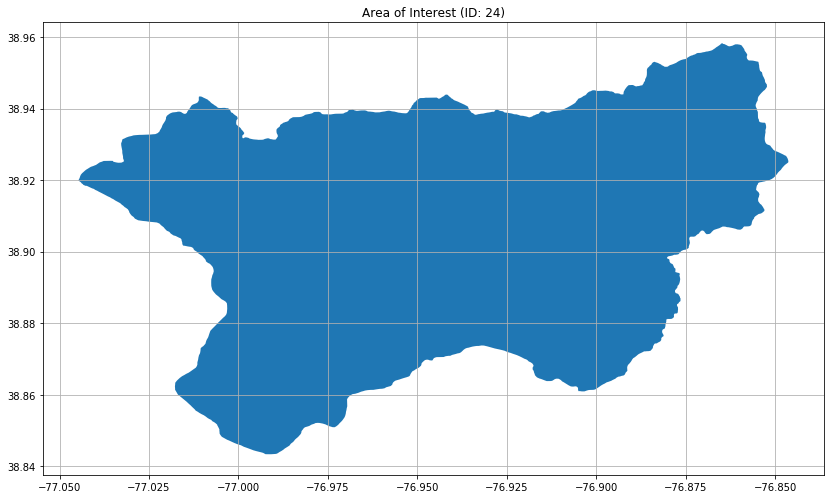

In [8]:
gdf_slice = gdf.loc[gdf[filter_field]==select_data].copy()

gdf_slice.crs = vector_crs_prj

geo_df = gdf_slice.to_crs(crs = noaa_data_crs)

plot_area_of_interest(geo_df, select_data, gdf_slice_column)

## Retrieve the Precipitation Frequency Data:

### Get list of zip files:

In [9]:
noaa_url = 'ftp://hdsc.nws.noaa.gov/pub/hdsc/data/{}/'.format(vol_code)

req = urllib.request.Request(noaa_url)
data = urllib.request.urlopen(req).read().decode().split()

copy_zips = []
for duration in durations:
    zips = [d for d in data if ('.zip' in d) and ('{}'.format(duration) in d) and ('ams' not in d)]
    copy_zips.append(zips)
    print('{} files found for {}'.format(len(zips), duration))

all_zips_list = list(np.array(copy_zips).flat)

30 files found for 06h
30 files found for 12h
30 files found for 24h
30 files found for 04d


### Iterate through zip files and build a table:

In [10]:
start = time.time()
results = []
print_zips=True
for i, zip_name in enumerate(all_zips_list):
    
    remote_file = os.path.join(noaa_url, zip_name)
    try:
        open_socket = urllib.request.urlopen(remote_file)   
        memfile = io.BytesIO(open_socket.read())
        memfile
        with ZipFile(memfile, 'r') as openzip:
            gridfiles = openzip.namelist()
            assert len(gridfiles) == 1,'Expected to find 1 file, found {}'.format(len(gridfiles))
            local_file = gridfiles[0]
    
            f = openzip.open(local_file)
            content = f.read() 
    
            local_file_to_disk = os.path.join(os.getcwd(), local_file)
    
            with open(local_file_to_disk, 'wb') as asc:
                asc.write(content)
        grid_data = parse_filename(zip_name, vol_code)
    
        grid_data['value'] = get_masked_mean_atlas14(geo_df, local_file_to_disk)    
        results.append(grid_data)
    
        os.remove(local_file_to_disk)
        if print_zips: print(i, zip_name)
        
    except:
        print("Unable to get data for {}...may be the result of a poor connection".format(zip_name))
        
print(round(time.time()-start), 'Seconds')

0 orb1000yr06ha.zip
1 orb1000yr06hal.zip
2 orb1000yr06hau.zip
3 orb100yr06ha.zip
4 orb100yr06hal.zip
5 orb100yr06hau.zip
6 orb10yr06ha.zip
7 orb10yr06hal.zip
8 orb10yr06hau.zip
9 orb1yr06ha.zip
10 orb1yr06hal.zip
11 orb1yr06hau.zip
12 orb200yr06ha.zip
13 orb200yr06hal.zip
14 orb200yr06hau.zip
15 orb25yr06ha.zip
16 orb25yr06hal.zip
17 orb25yr06hau.zip
18 orb2yr06ha.zip
19 orb2yr06hal.zip
20 orb2yr06hau.zip
21 orb500yr06ha.zip
22 orb500yr06hal.zip
23 orb500yr06hau.zip
24 orb50yr06ha.zip
25 orb50yr06hal.zip
26 orb50yr06hau.zip
27 orb5yr06ha.zip
28 orb5yr06hal.zip
29 orb5yr06hau.zip
30 orb1000yr12ha.zip
31 orb1000yr12hal.zip
32 orb1000yr12hau.zip
33 orb100yr12ha.zip
34 orb100yr12hal.zip
35 orb100yr12hau.zip
36 orb10yr12ha.zip
37 orb10yr12hal.zip
38 orb10yr12hau.zip
39 orb1yr12ha.zip
40 orb1yr12hal.zip
41 orb1yr12hau.zip
42 orb200yr12ha.zip
43 orb200yr12hal.zip
44 orb200yr12hau.zip
45 orb25yr12ha.zip
46 orb25yr12hal.zip
47 orb25yr12hau.zip
48 orb2yr12ha.zip
49 orb2yr12hal.zip
50 orb2yr12hau

### Create an outputs directory:

In [11]:
if not os.path.isdir(outputs_dir):
    os.mkdir(outputs_dir)

### Transform the data to a dataframe and save:

In [12]:
df = pd.DataFrame.from_dict(results)

writer = pd.ExcelWriter(outputs_dir/'PrecipTable_{}.xlsx'.format(select_data))

for i, d in enumerate(durations):
    table = pd.pivot_table(df[df['duration']==d], values = 'value', index=['TR'], columns=['statistic'])
    table.index.name='Tr'
    table.columns.name = None
    table = table.sort_values(by=['Expected Value'])
    table.to_excel(writer, sheet_name='AreaDepths_{}'.format(dur_names[i]))
    print(table)
    
writer.save()

      Expected Value  Lower (90%)  Upper (90%)
Tr                                            
1           1.856218     1.691229     2.055380
2           2.247564     2.043832     2.484978
5           2.840453     2.572693     3.138844
10          3.326732     2.998078     3.676134
25          4.047603     3.613844     4.471201
50          4.660737     4.122061     5.155084
100         5.324173     4.665251     5.902955
200         6.041682     5.236464     6.726922
500         7.099184     6.046888     7.972961
1000        7.990955     6.703486     9.034240
      Expected Value  Lower (90%)  Upper (90%)
Tr                                            
1           2.247676     2.025324     2.526257
2           2.714402     2.442274     3.048341
5           3.449922     3.095034     3.872665
10          4.082397     3.639358     4.577916
25          5.047732     4.451732     5.655620
50          5.894514     5.143363     6.610793
100         6.835257     5.888581     7.688453
200         7

---